#                                                               Truncated SVD-  Amazon fine food reviews

#### This Kernel explores the TruncatedSVD and how it can be used on Amazon Food reviews to gather meaningful Clusters

In [49]:
import os
print(os.listdir("../input"))

['database.sqlite', 'hashes.txt', 'Reviews.csv']


In [ ]:
# Import all the required libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from collections import Counter


from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score

# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import re
import string
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# using the SQLite Table to read data.
import sqlite3
show_tables = "select tbl_name from sqlite_master where type = 'table'" 
conn = sqlite3.connect('../input/database.sqlite') 
pd.read_sql(show_tables,conn)

In [ ]:
# Data cleaning steps
#filtering only positive and negative reviews i.e. SKIPPING reviews with Score=3

filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", conn) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return '0'
    return '1'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

#Display attributes 
filtered_data.head()

In [ ]:
#Data Cleaning: Deduplication:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", conn)
display.head()

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

# Cleadning the data for Helpfulness duplication

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", conn)

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

In [ ]:
# Get 10k  Pts for this analysis

from random import sample
final_dataset = final.ix[np.random.choice(final.index, 10000)]

In [ ]:
#Sorting data according to Time in ascending order
KMEANS_DATASET=final_dataset.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
# find sentences containing HTML tags (DATASET FOR BRUTEFORCE)
import re
i=0;
for sent in KMEANS_DATASET['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;
    
# find sentences containing HTML tags (DATASET FOR KD_TREE)
import re
i=0;
for sent in KMEANS_DATASET['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

# STEMMING
import nltk.corpus
from nltk.corpus import stopwords

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(stop)
#print('************************************')
#print(sno.stem('tasty'))


In [ ]:
# LEMMATIZATION
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in KMEANS_DATASET['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (KMEANS_DATASET['Score'].values)[i] == '1': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(KMEANS_DATASET['Score'].values)[i] == '0':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [ ]:
KMEANS_DATASET['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
KMEANS_DATASET['CleanedText']=KMEANS_DATASET['CleanedText'].str.decode("utf-8")


In [ ]:
# define column names
names = ['CleanedText']


# create design matrix X and target vector y
X =  KMEANS_DATASET[names]
Y = KMEANS_DATASET['Score']

X_train, X_test = model_selection.train_test_split(X,test_size=0.1, random_state=0)


# Getting the Top 2000 TFIDF features

In [ ]:
tf_idf_vect = TfidfVectorizer()

tfidf = tf_idf_vect.fit(X['CleanedText'].values)

tfidf_train = tfidf.transform(X['CleanedText'].values)

#tfidf_test  = tfidf.transform(X_test['CleanedText'].values)

features = tf_idf_vect.get_feature_names()

In [ ]:
features_set= (np.asarray(features)[0:5,])
print(features_set)

# MODULE 1: ANALYSIS OF TOP 2000 TFIDF FEATURES

# Part 1: get the Top 2000 TFIDF Features

In [ ]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=10000):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    #top_feats = [(features[i], row[i]) for i in topn_ids]
    top_feats = [(features[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    #df.columns = ['feature', 'tfidf']
    df.columns = ['feature']
    return top_feats

top_tfidf = top_tfidf_feats(tfidf_train[1,:].toarray()[0],features,2000)

# Part 2 : Created Word Co-Occurence Matrix with neighbourhood = 5

In [ ]:
import numpy as np
import pandas as pd

ctxs = list(top_tfidf)

l_unique = list(set((' '.join(ctxs)).split(' ')))
mat = np.zeros((len(l_unique), len(l_unique)))

nei = []
nei_size = 5

for ctx in ctxs:
    words = ctx.split(' ')

    for i, _ in enumerate(words):
        nei.append(words[i])

        if len(nei) > (nei_size * 2) + 1:
            nei.pop(0)

        pos = int(len(nei) / 2)
        for j, _ in enumerate(nei):
           if nei[j]  in l_unique and words[i] in l_unique:
              mat[l_unique.index(nei[j]), l_unique.index(words[i])] += 1

mat = pd.DataFrame(mat)
mat.index = l_unique
mat.columns = l_unique
print(mat)

# Part 3: Word Co-Occurence Matrix Decomposition using SVD

In [ ]:
import numpy as np

la= np.linalg

#u, s, vh = la.svd(mat, full_matrices=True)

U, d, Vt = la.svd( mat, full_matrices=False )

assert np.all( d[:-1] >= d[1:] )  # sorted

eigen = d**2/2000

sumvariance = np.cumsum(eigen)

sumvariance /= sumvariance[-1]

i= np.arange(1,2001)

# Part 4: Get best value of 'k', based on explained variance of matrix U

In [ ]:
import matplotlib.pyplot as plt
plt.plot( i,sumvariance)
plt.rcParams["figure.figsize"]= [7,7]

# Part 5: TruncatedSVD on U to reduce U to 'k' components

In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

component_matrix =[]
variance_matrix = []


model = TruncatedSVD(n_components=250).fit(U)
X_proj = model.transform(U)
    
explained_variances = round(np.mean(np.var(X_proj, axis=0) / np.var(U, axis=0).sum()),5)



In [ ]:
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import csr_matrix

standardized_data_sparse_train = csr_matrix(U)

tsvd = TruncatedSVD(n_components=250)

standardized_data_sparse_tsvd_train = tsvd.fit(standardized_data_sparse_train).transform(standardized_data_sparse_train)




# Part 6: # Aggregate the Features and visualize the Clusters (K Means)

In [ ]:


from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial import distance
from scipy.spatial.distance import cdist

clusters=range(1,40)
meandist=[]

meandist = []
Inertia_matrix = []
Assignment_matrix = []

for k in clusters:
    kmeanModel = KMeans(init='k-means++',n_clusters=k).fit(standardized_data_sparse_tsvd_train)
    kmeanModel.fit(standardized_data_sparse_tsvd_train)
    Assignment_matrix.append(kmeanModel.predict(standardized_data_sparse_tsvd_train))
    #meandist.append(sum(np.min(cdist(bow_train_vector, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / bow_train_vector.shape[0])
    Inertia_matrix.append( kmeanModel.inertia_)

# Finding Optimal K from the elbow plot

In [ ]:
# Finding Optimal K from the elbow plot

fig = plt.figure()
ax = fig.add_subplot(111) 


# Set the figure width and heights
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.plot(clusters, Inertia_matrix)
ax.plot(clusters,Inertia_matrix, marker='o', markersize=4,markeredgewidth=5, markeredgecolor='b')

plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Using Optimal K get the Centroids,Labels and Inertia details

In [ ]:
from sklearn import cluster
centroids,labels,inertia = cluster.k_means(standardized_data_sparse_tsvd_train,n_clusters=25)



# Part 7: Take a word and gather 100 words closer to it based on Cosine Similarity

* ### Here the word taken  is :

In [77]:
top_tfidf[8] 

'cafe'

In [78]:
from scipy import linalg, mat, dot

a = standardized_data_sparse_tsvd_train[8]

cosine_similarity_values=[]
cosine_similarity_index = []

for i in range(0,2000):
    c = abs(dot(a,standardized_data_sparse_tsvd_train[i].T)/linalg.norm(a)/linalg.norm(standardized_data_sparse_tsvd_train))
    cosine_similarity_index.append(i)
    cosine_similarity_values.append(c)


In [79]:
c = np.column_stack((cosine_similarity_index,cosine_similarity_values))

In [81]:
datanew = c[c[:,1].argsort()[::-1]]
#print(datanew)

In [82]:
top100_words = (np.asarray(datanew)[0:100,])
#print(top100_words)

In [83]:
top100_index= [int(row[0]) for row in top100_words]

In [ ]:
#np.asarray(top100_index).shape

In [57]:
top_closest_words= np.asarray(top_tfidf)[top100_index]

In [84]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial import distance
from scipy.spatial.distance import cdist

clusters=range(1,5)
meandist=[]

meandist = []
Inertia_matrix = []
Assignment_matrix = []

for k in clusters:
    kmeanModel = KMeans(init='k-means++',n_clusters=k).fit(standardized_data_sparse_tsvd_train[top100_index])
    kmeanModel.fit(standardized_data_sparse_tsvd_train[top100_index])
    Assignment_matrix.append(kmeanModel.predict(standardized_data_sparse_tsvd_train[top100_index]))
    Inertia_matrix.append( kmeanModel.inertia_)

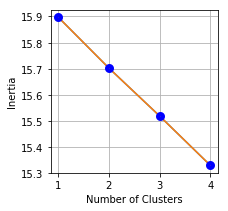

In [86]:
# Finding Optimal K from the elbow plot

fig = plt.figure()
ax = fig.add_subplot(111) 


# Set the figure width and heights
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 1
fig_size[1] = 1
plt.rcParams["figure.figsize"] = fig_size

plt.plot(clusters, Inertia_matrix)
ax.plot(clusters,Inertia_matrix, marker='o', markersize=4,markeredgewidth=5, markeredgecolor='b')

plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [87]:
from sklearn import cluster
centroids,labels,inertia = cluster.k_means(standardized_data_sparse_tsvd_train[top100_index],n_clusters=3)

# All the Cluster details:
{i: np.where(kmeanModel.labels_ == i)[0] for i in range(kmeanModel.n_clusters)}



{0: array([12, 69, 81, 86, 88]),
 1: array([ 3,  4,  5,  7, 16, 20, 21, 22, 23, 24, 32, 35, 36, 39, 42, 45, 52,
        60, 61, 62, 67, 68, 70, 72, 75, 77, 91, 92, 98]),
 2: array([ 0,  1,  6, 10, 11, 13, 15, 17, 18, 19, 25, 26, 27, 28, 29, 30, 31,
        34, 38, 40, 43, 46, 47, 49, 51, 53, 54, 55, 56, 57, 59, 63, 65, 66,
        71, 73, 74, 76, 78, 80, 82, 83, 85, 87, 90, 93, 94, 95, 96, 97, 99]),
 3: array([ 2,  8,  9, 14, 33, 37, 41, 44, 48, 50, 58, 64, 79, 84, 89])}

In [88]:
# No of words in Cluster 0
sum(kmeanModel.labels_ == 0)

5

In [89]:
# No of words in Cluster 1
sum(kmeanModel.labels_ == 1)

29

In [90]:
# No of words in Cluster 2
sum(kmeanModel.labels_ == 2)

51

In [91]:
# No of words in Cluster 3
sum(kmeanModel.labels_ == 3)

15

# Part 8: Display the Clusters 

The WordCloud for Cluster 1 is given Below:


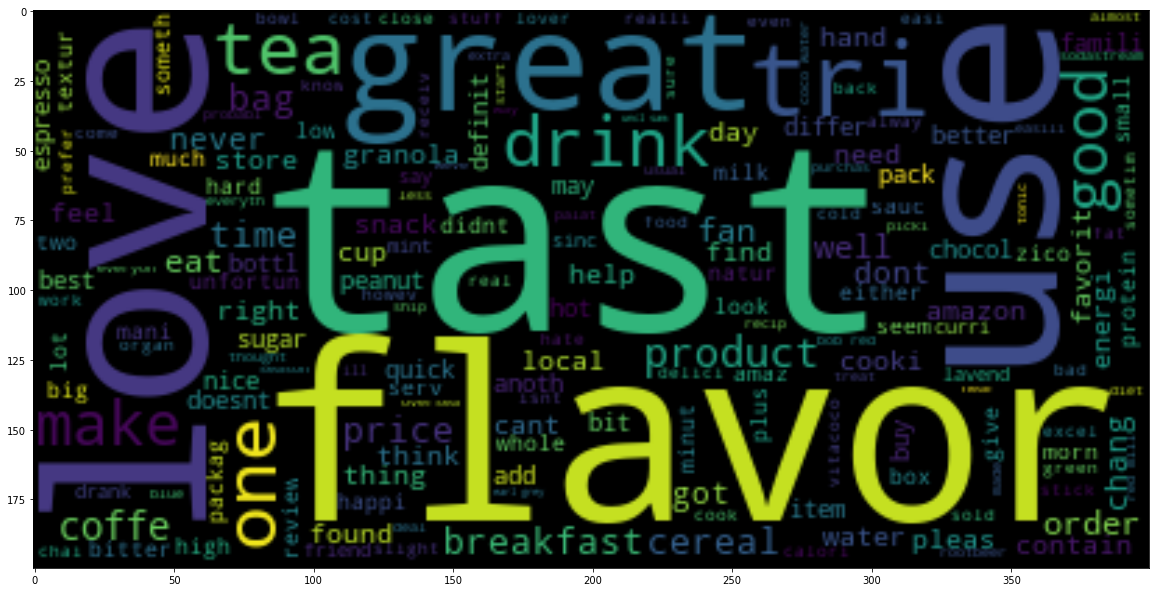

In [92]:
#from sklearn import cluster
#centroids,labels,inertia = cluster.k_means(standardized_data_sparse_tsvd_train,n_clusters=25)

# All the Cluster details:
#{i: np.where(kmeanModel.labels_ == i)[0] for i in range(kmeanModel.n_clusters)}

# Getting details of Cluster 5 

index= np.where(kmeanModel.labels_ == 2)[0]
index_new = np.asarray(index)
cluster5 = str(np.asarray(X_train)[index_new,])

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

print("The WordCloud for Cluster 1 is given Below:")

wordcloud = WordCloud().generate(str(cluster5))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size

plt.imshow(wordcloud, interpolation='bilinear')
plt.show()


###  This cluster is themed around   "Cafe"- we have words like coffe, tea, cup, breakfast, cereal,espresso,eat,chai  agregated around this theme.

# MODULE 2: ANALYSIS OF TOP 5000 TFIDF FEATURES

## #  Part 1: get the Top 5k TFIDF Features

In [93]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=5000):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    #top_feats = [(features[i], row[i]) for i in topn_ids]
    top_feats = [(features[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    #df.columns = ['feature', 'tfidf']
    df.columns = ['feature']
    return top_feats

top_tfidf = top_tfidf_feats(tfidf_train[1,:].toarray()[0],features,5000)

### Part 2 : Created Word Co-Occurence Matrix with neighbourhood = 5

In [94]:
import numpy as np
import pandas as pd

ctxs = list(top_tfidf)

l_unique = list(set((' '.join(ctxs)).split(' ')))
mat = np.zeros((len(l_unique), len(l_unique)))

nei = []
nei_size = 5

for ctx in ctxs:
    words = ctx.split(' ')

    for i, _ in enumerate(words):
        nei.append(words[i])

        if len(nei) > (nei_size * 2) + 1:
            nei.pop(0)

        pos = int(len(nei) / 2)
        for j, _ in enumerate(nei):
           if nei[j]  in l_unique and words[i] in l_unique:
              mat[l_unique.index(nei[j]), l_unique.index(words[i])] += 1

mat = pd.DataFrame(mat)
mat.index = l_unique
mat.columns = l_unique
print(mat)

             drunk  hunger  evo  hondura  ...    boil  epa  bittersweet  smell
drunk          1.0     0.0  0.0      0.0  ...     0.0  0.0          0.0    0.0
hunger         0.0     1.0  0.0      0.0  ...     0.0  0.0          0.0    0.0
evo            0.0     0.0  1.0      0.0  ...     0.0  0.0          0.0    0.0
hondura        0.0     0.0  0.0      1.0  ...     0.0  0.0          0.0    0.0
box            0.0     0.0  0.0      0.0  ...     0.0  0.0          0.0    0.0
fret           0.0     0.0  0.0      0.0  ...     0.0  0.0          0.0    0.0
ginseng        0.0     0.0  0.0      0.0  ...     0.0  0.0          0.0    0.0
hcg            0.0     0.0  0.0      0.0  ...     0.0  0.0          0.0    0.0
impuls         0.0     0.0  0.0      0.0  ...     0.0  0.0          0.0    0.0
accomod        0.0     0.0  0.0      0.0  ...     0.0  0.0          0.0    0.0
help           0.0     0.0  0.0      0.0  ...     0.0  0.0          0.0    0.0
farley         0.0     0.0  0.0      0.0  ...     0.

### ## Part 3: Word Co-Occurence Matrix Decomposition using SVD

In [95]:
import numpy as np

la= np.linalg

#u, s, vh = la.svd(mat, full_matrices=True)

U, d, Vt = la.svd( mat, full_matrices=False )

assert np.all( d[:-1] >= d[1:] )  # sorted

eigen = d**2/5000

sumvariance = np.cumsum(eigen)

sumvariance /= sumvariance[-1]

i= np.arange(1,5001)

#### Part 4: Get best value of 'k', based on explained variance of matrix U

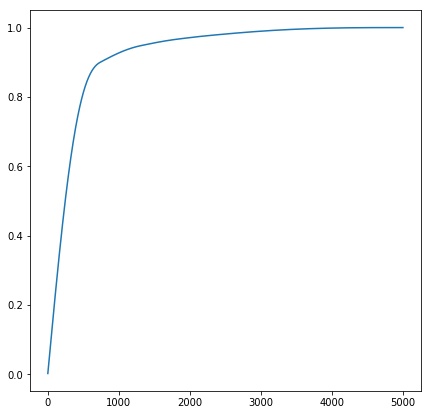

In [97]:
import matplotlib.pyplot as plt
plt.plot( i,sumvariance)
plt.rcParams["figure.figsize"]= [2,2]

### Part 5: TruncatedSVD on U to reduce U to 'k' components  (from the elbow curve)

In [98]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

component_matrix =[]
variance_matrix = []


model = TruncatedSVD(n_components=500).fit(U)
X_proj = model.transform(U)
    
explained_variances = round(np.mean(np.var(X_proj, axis=0) / np.var(U, axis=0).sum()),5)

In [103]:
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import csr_matrix

standardized_data_sparse_train = csr_matrix(U)

tsvd = TruncatedSVD(n_components=500)

standardized_data_sparse_tsvd_train = tsvd.fit(standardized_data_sparse_train).transform(standardized_data_sparse_train)


#### Part 6: # Aggregate the Features and visualize the Clusters (K Means)

In [100]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial import distance
from scipy.spatial.distance import cdist

clusters=range(1,40)
meandist=[]

meandist = []
Inertia_matrix = []
Assignment_matrix = []

for k in clusters:
    kmeanModel = KMeans(init='k-means++',n_clusters=k).fit(standardized_data_sparse_tsvd_train)
    kmeanModel.fit(standardized_data_sparse_tsvd_train)
    Assignment_matrix.append(kmeanModel.predict(standardized_data_sparse_tsvd_train))
    #meandist.append(sum(np.min(cdist(bow_train_vector, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / bow_train_vector.shape[0])
    Inertia_matrix.append( kmeanModel.inertia_)

### Finding Optimal K from the elbow plot

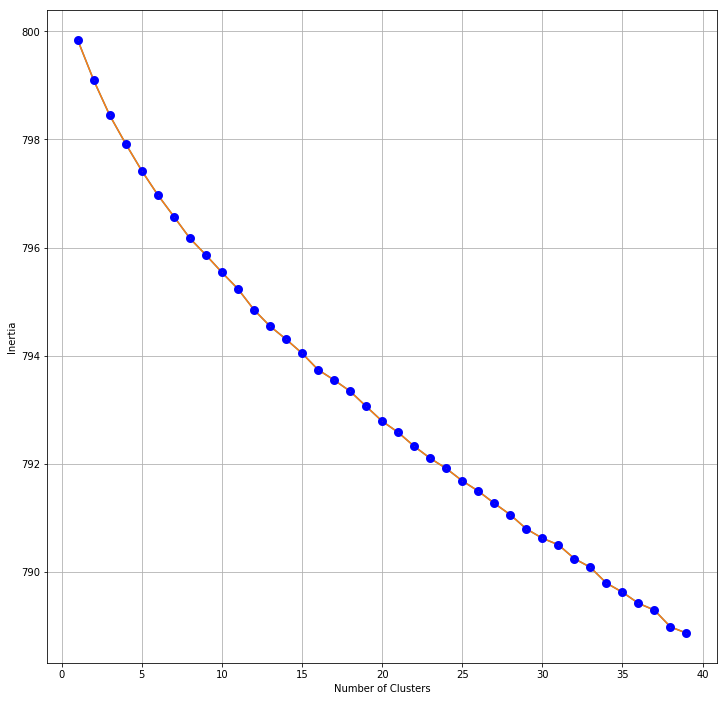

In [105]:
# Finding Optimal K from the elbow plot

fig = plt.figure()
ax = fig.add_subplot(111) 


# Set the figure width and heights
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size

plt.plot(clusters, Inertia_matrix)
ax.plot(clusters,Inertia_matrix, marker='o', markersize=4,markeredgewidth=5, markeredgecolor='b')

plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [106]:
# Using Optimal K get the Centroids,Labels and Inertia details
from sklearn import cluster
centroids,labels,inertia = cluster.k_means(standardized_data_sparse_tsvd_train,n_clusters=20)


# Part 7: Take a word and gather 100 words closer to it based on Cosine Similarity

![](http://)### Here the word taken  is 

In [157]:
top_tfidf[1000]

'eighteen'

In [158]:
from scipy import linalg, mat, dot

a = standardized_data_sparse_tsvd_train[1000]

cosine_similarity_values=[]
cosine_similarity_index = []

for i in range(0,5000):
    c = abs(dot(a,standardized_data_sparse_tsvd_train[i].T)/linalg.norm(a)/linalg.norm(standardized_data_sparse_tsvd_train))
    cosine_similarity_index.append(i)
    cosine_similarity_values.append(c)

In [159]:
c = np.column_stack((cosine_similarity_index,cosine_similarity_values))

datanew = c[c[:,1].argsort()[::-1]]

top100_words = (np.asarray(datanew)[0:100,])

top100_index= [int(row[0]) for row in top100_words]

top_closest_words= np.asarray(top_tfidf)[top100_index]



In [160]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial import distance
from scipy.spatial.distance import cdist

clusters=range(1,5)
meandist=[]

meandist = []
Inertia_matrix = []
Assignment_matrix = []

for k in clusters:
    kmeanModel = KMeans(init='k-means++',n_clusters=k).fit(standardized_data_sparse_tsvd_train[top100_index])
    kmeanModel.fit(standardized_data_sparse_tsvd_train[top100_index])
    Assignment_matrix.append(kmeanModel.predict(standardized_data_sparse_tsvd_train[top100_index]))
    Inertia_matrix.append( kmeanModel.inertia_)

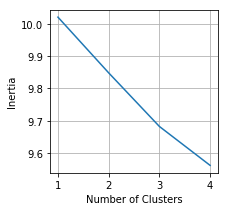

In [162]:
# Finding Optimal K from the elbow plot

fig = plt.figure()
#ax = fig.add_subplot(111) 


# Set the figure width and heights
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 3
fig_size[1] = 3
plt.rcParams["figure.figsize"] = fig_size

plt.plot(clusters, Inertia_matrix)
ax.plot(clusters,Inertia_matrix, marker='o', markersize=4,markeredgewidth=5, markeredgecolor='b')

plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [163]:
from sklearn import cluster
centroids,labels,inertia = cluster.k_means(standardized_data_sparse_tsvd_train[top100_index],n_clusters=3)

# All the Cluster details:
{i: np.where(kmeanModel.labels_ == i)[0] for i in range(kmeanModel.n_clusters)}

{0: array([ 3, 15, 48, 58, 74, 86, 90]),
 1: array([ 1,  6,  8, 14, 24, 28, 30, 31, 33, 46, 52, 53, 54, 55, 60, 62, 64,
        68, 69, 70, 71, 76, 77, 78, 80, 82, 89, 95, 96]),
 2: array([ 7, 16, 22, 25, 29, 34, 43, 50, 56, 75, 98]),
 3: array([ 0,  2,  4,  5,  9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 23, 26, 27,
        32, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 47, 49, 51, 57, 59, 61,
        63, 65, 66, 67, 72, 73, 79, 81, 83, 84, 85, 87, 88, 91, 92, 93, 94,
        97, 99])}

In [168]:
# No of words in Cluster 0
sum(kmeanModel.labels_ == 0)

7

In [167]:
# No of words in Cluster 1
sum(kmeanModel.labels_ == 1)

29

In [166]:
# No of words in Cluster 2
sum(kmeanModel.labels_ == 2)

11

In [165]:
# No of words in Cluster 3
sum(kmeanModel.labels_ == 3)

53

# Part 8: Display the Clusters with max number of words

The WordCloud for the Cluster is given Below:


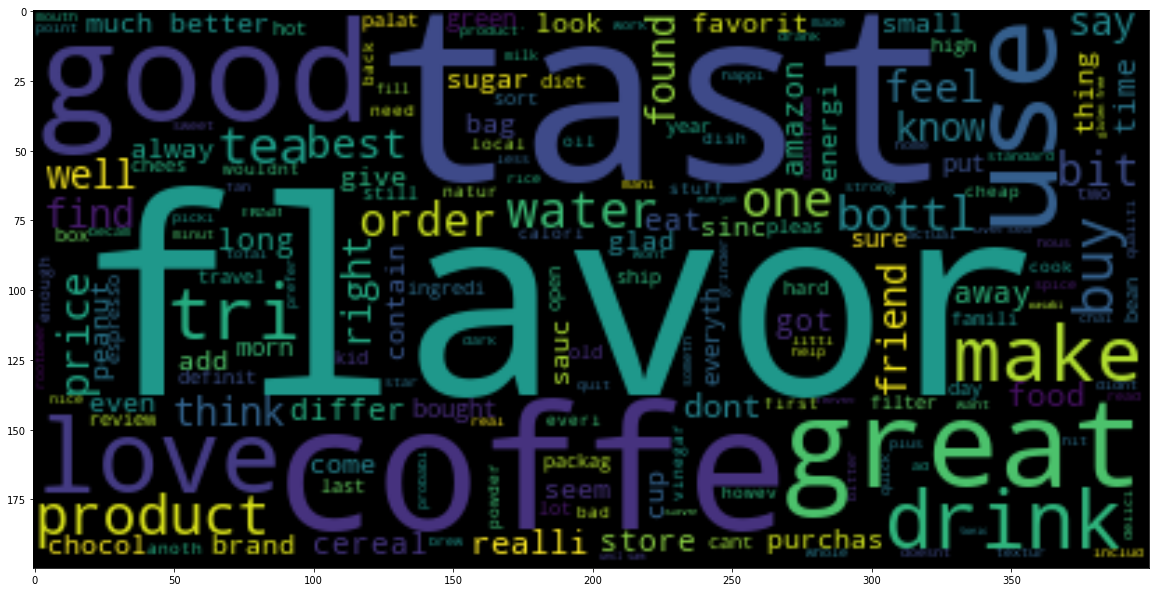

In [169]:

index= np.where(kmeanModel.labels_ == 3)[0]
index_new = np.asarray(index)
cluster5 = str(np.asarray(X_train)[index_new,])

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

print("The WordCloud for the Cluster is given Below:")

wordcloud = WordCloud().generate(str(cluster5))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size

plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

# Cluster theme is "Diet"  Indicated by words like  cereal, energi,Green, diet etc.

# Module 3: Analysis of top 10K TFIDF features

#### Part 1: get the Top 10k  TFIDF Features

In [188]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=10000):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    #top_feats = [(features[i], row[i]) for i in topn_ids]
    top_feats = [(features[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    #df.columns = ['feature', 'tfidf']
    df.columns = ['feature']
    return top_feats

top_tfidf = top_tfidf_feats(tfidf_train[1,:].toarray()[0],features,10000)

### Part 2 : Created Word Co-Occurence Matrix with neighbourhood = 5

In [189]:
import numpy as np
import pandas as pd

ctxs = list(top_tfidf)

l_unique = list(set((' '.join(ctxs)).split(' ')))
mat = np.zeros((len(l_unique), len(l_unique)))

nei = []
nei_size = 5

for ctx in ctxs:
    words = ctx.split(' ')

    for i, _ in enumerate(words):
        nei.append(words[i])

        if len(nei) > (nei_size * 2) + 1:
            nei.pop(0)

        pos = int(len(nei) / 2)
        for j, _ in enumerate(nei):
           if nei[j]  in l_unique and words[i] in l_unique:
              mat[l_unique.index(nei[j]), l_unique.index(words[i])] += 1

mat = pd.DataFrame(mat)
mat.index = l_unique
mat.columns = l_unique
print(mat)

             underneath  hondura  constitu  ...    lamb  headach  joyva
underneath          1.0      0.0       0.0  ...     0.0      0.0    0.0
hondura             0.0      1.0       0.0  ...     0.0      0.0    0.0
constitu            0.0      0.0       1.0  ...     0.0      0.0    0.0
copycat             0.0      0.0       0.0  ...     0.0      0.0    0.0
ginseng             0.0      0.0       0.0  ...     0.0      0.0    0.0
take                0.0      0.0       0.0  ...     0.0      0.0    0.0
impuls              0.0      0.0       0.0  ...     0.0      0.0    0.0
tastybit            0.0      0.0       0.0  ...     0.0      0.0    0.0
help                0.0      0.0       0.0  ...     0.0      0.0    0.0
hectic              0.0      0.0       0.0  ...     0.0      0.0    0.0
jake                0.0      0.0       0.0  ...     0.0      0.0    0.0
hlaf                0.0      0.0       0.0  ...     0.0      0.0    0.0
kenya               0.0      0.0       0.0  ...     0.0      0.0

### Part 3: Word Co-Occurence Matrix Decomposition using SVD

In [190]:
import numpy as np

la= np.linalg

#u, s, vh = la.svd(mat, full_matrices=True)

U, d, Vt = la.svd( mat, full_matrices=False )

assert np.all( d[:-1] >= d[1:] )  # sorted

eigen = d**2/10000

sumvariance = np.cumsum(eigen)

sumvariance /= sumvariance[-1]

i= np.arange(1,10001)

#### Part 4: Get best value of 'k', based on explained variance of matrix U

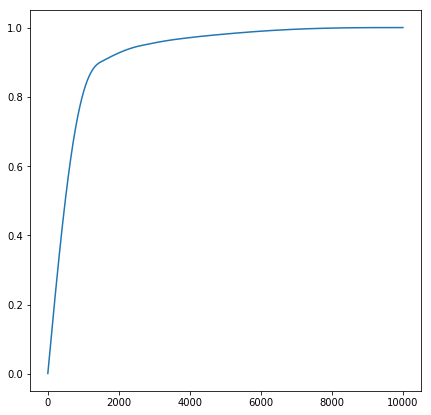

In [192]:
import matplotlib.pyplot as plt
plt.plot( i,sumvariance)
plt.rcParams["figure.figsize"]= [2,2]

### Part 5: TruncatedSVD on U to reduce U to 'k' components

In [193]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

component_matrix =[]
variance_matrix = []


model = TruncatedSVD(n_components=1200).fit(U)
X_proj = model.transform(U)
    
explained_variances = round(np.mean(np.var(X_proj, axis=0) / np.var(U, axis=0).sum()),5)

In [194]:
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import csr_matrix

standardized_data_sparse_train = csr_matrix(U)

tsvd = TruncatedSVD(n_components=1200)

standardized_data_sparse_tsvd_train = tsvd.fit(standardized_data_sparse_train).transform(standardized_data_sparse_train)

#### Part 6: # Aggregate the Features and visualize the Clusters (K Means)

In [195]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial import distance
from scipy.spatial.distance import cdist

clusters=range(1,40)
meandist=[]

meandist = []
Inertia_matrix = []
Assignment_matrix = []

for k in clusters:
    kmeanModel = KMeans(init='k-means++',n_clusters=k).fit(standardized_data_sparse_tsvd_train)
    kmeanModel.fit(standardized_data_sparse_tsvd_train)
    Assignment_matrix.append(kmeanModel.predict(standardized_data_sparse_tsvd_train))
    #meandist.append(sum(np.min(cdist(bow_train_vector, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / bow_train_vector.shape[0])
    Inertia_matrix.append( kmeanModel.inertia_)

#### Finding Optimal K from the elbow plot


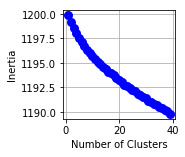

In [196]:
# Finding Optimal K from the elbow plot

fig = plt.figure()
ax = fig.add_subplot(111) 


# Set the figure width and heights
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.plot(clusters, Inertia_matrix)
ax.plot(clusters,Inertia_matrix, marker='o', markersize=4,markeredgewidth=5, markeredgecolor='b')

plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [197]:
from sklearn import cluster
centroids,labels,inertia = cluster.k_means(standardized_data_sparse_tsvd_train,n_clusters=20)




# Part 7: Take a word and gather 100 words closer to it based on Cosine Similarity

### Here the word taken  is : 

In [219]:
top_tfidf[1234]

'enfamil'

In [220]:
from scipy import linalg, mat, dot

a = standardized_data_sparse_tsvd_train[1234]

cosine_similarity_values=[]
cosine_similarity_index = []

for i in range(0,10000):
    c = abs(dot(a,standardized_data_sparse_tsvd_train[i].T)/linalg.norm(a)/linalg.norm(standardized_data_sparse_tsvd_train))
    cosine_similarity_index.append(i)
    cosine_similarity_values.append(c)


In [221]:
c = np.column_stack((cosine_similarity_index,cosine_similarity_values))

datanew = c[c[:,1].argsort()[::-1]]


top100_words = (np.asarray(datanew)[0:100,])

top100_index= [int(row[0]) for row in top100_words]

top_closest_words= np.asarray(top_tfidf)[top100_index]



In [222]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial import distance
from scipy.spatial.distance import cdist

clusters=range(1,6)
meandist=[]

meandist = []
Inertia_matrix = []
Assignment_matrix = []

for k in clusters:
    kmeanModel = KMeans(init='k-means++',n_clusters=k).fit(standardized_data_sparse_tsvd_train[top100_index])
    kmeanModel.fit(standardized_data_sparse_tsvd_train[top100_index])
    Assignment_matrix.append(kmeanModel.predict(standardized_data_sparse_tsvd_train[top100_index]))
    Inertia_matrix.append( kmeanModel.inertia_)

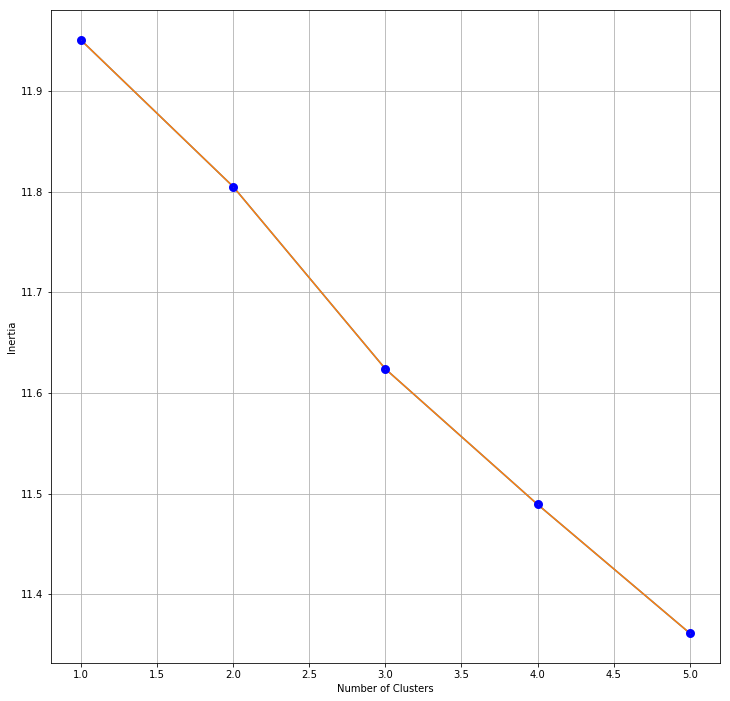

In [223]:
# Finding Optimal K from the elbow plot

fig = plt.figure()
ax = fig.add_subplot(111) 


# Set the figure width and heights
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 3
fig_size[1] = 3
plt.rcParams["figure.figsize"] = fig_size

plt.plot(clusters, Inertia_matrix)
ax.plot(clusters,Inertia_matrix, marker='o', markersize=4,markeredgewidth=5, markeredgecolor='b')

plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [224]:
from sklearn import cluster
centroids,labels,inertia = cluster.k_means(standardized_data_sparse_tsvd_train[top100_index],n_clusters=3)

# All the Cluster details:

{i: np.where(kmeanModel.labels_ == i)[0] for i in range(kmeanModel.n_clusters)}



{0: array([ 3, 10, 21, 33, 40, 69, 74, 79, 92, 96]),
 1: array([ 4,  9, 11, 16, 20, 23, 24, 34, 36, 43, 44, 45, 46, 47, 50, 51, 55,
        56, 57, 58, 61, 65, 66, 77, 83, 84, 86, 95, 98, 99]),
 2: array([ 0,  5,  6,  7,  8, 12, 13, 14, 15, 18, 19, 26, 27, 28, 29, 31, 32,
        35, 39, 41, 49, 54, 59, 62, 67, 68, 70, 72, 73, 75, 78, 82, 87, 88,
        91, 93, 97]),
 3: array([17, 42]),
 4: array([ 1,  2, 22, 25, 30, 37, 38, 48, 52, 53, 60, 63, 64, 71, 76, 80, 81,
        85, 89, 90, 94])}

In [225]:
# No of words in Cluster 1
sum(kmeanModel.labels_ == 0)

10

In [226]:
# No of words in Cluster 2
sum(kmeanModel.labels_ == 1)

30

In [227]:
# No of words in Cluster 3
sum(kmeanModel.labels_ == 2)

37

In [228]:
# No of words in Cluster 4
sum(kmeanModel.labels_ == 3)

2

##  Part 8: Display the Cluster which has the maximum number of words 

The WordCloud for the cluster is given Below:


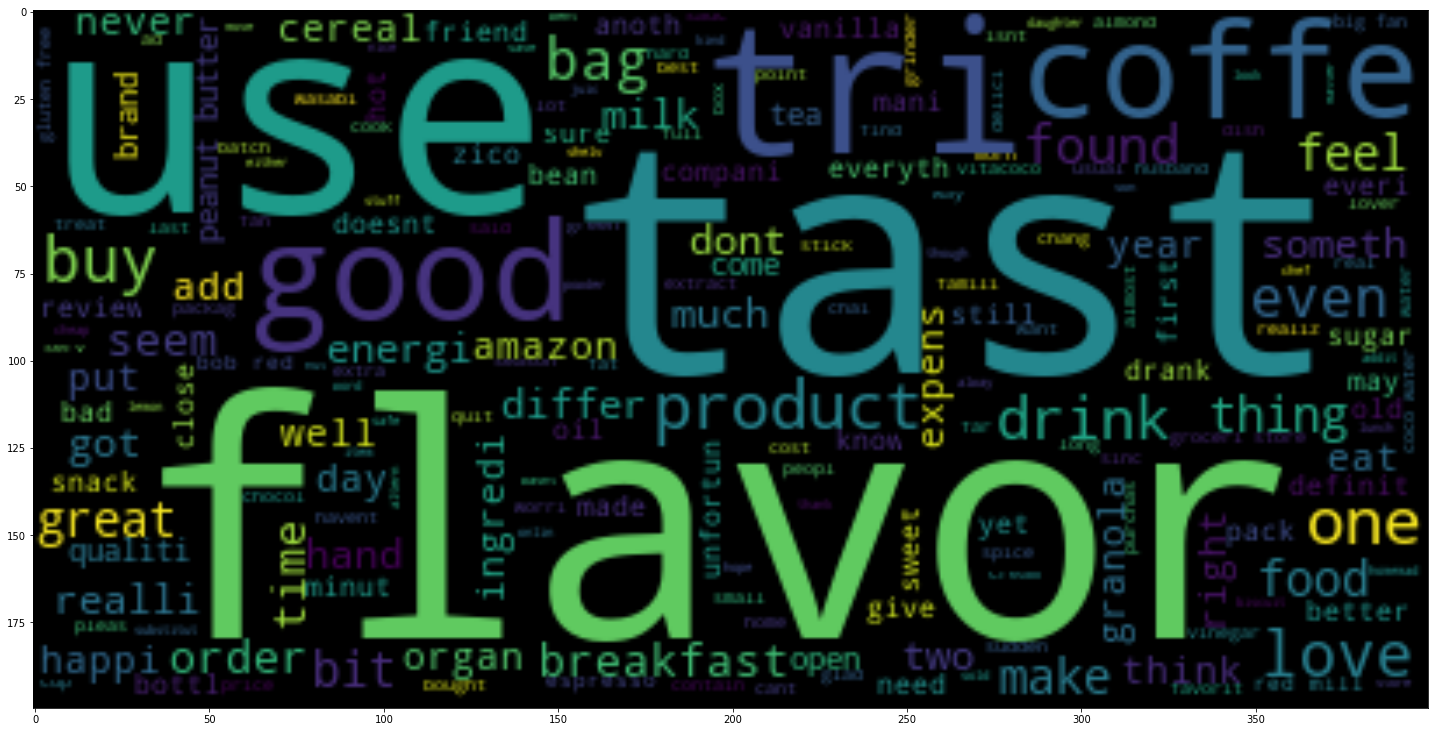

In [230]:

index= np.where(kmeanModel.labels_ == 2)[0]
index_new = np.asarray(index)
cluster5 = str(np.asarray(X_train)[index_new,])

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

print("The WordCloud for the cluster is given Below:")

wordcloud = WordCloud().generate(str(cluster5))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 25
fig_size[1] = 25
plt.rcParams["figure.figsize"] = fig_size

plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

#  Theme of this cluster is Fitness:  we have words like Breakfast, cereal,energi,Granola,Peanut Butter